# Distillation via x0 prediction 

## Imports

In [1]:
from util_x0 import *
import wandb

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2



c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


## Load Models

In [2]:
config_path=f"{cwd}/models/configs/cin256-v2-x0.yaml"
model_path=f"{cwd}/models/cin256_original.ckpt"

teacher = create_models(config_path, model_path, student=False)

Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


Test teacher:

In [5]:
config_path=f"{cwd}/models/configs/cin256-v2-custom.yaml"
model_path=f"{cwd}/models/cin256_original.ckpt"

teacher2 = create_models(config_path, model_path, student=False)

Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [48]:
timesteps =  400
# uc = teacher.get_learned_conditioning({teacher.cond_stage_key: torch.tensor(1*[1000]).to(teacher.device)})
xc = torch.tensor([992])
teacher2.num_timesteps = timesteps
# teacher2.register_schedule(given_betas=None, beta_schedule="cosine", timesteps=timesteps)
c = teacher2.get_learned_conditioning({teacher2.cond_stage_key: xc.to(teacher2.device)})
img, x0 = teacher2.progressive_denoising(cond=c, shape=[3, 64, 64], verbose=True, callback=None, quantize_denoised=False,
                              img_callback=None, mask=None, x0=None, temperature=1., noise_dropout=0.,
                              score_corrector=None, corrector_kwargs=None, batch_size=1, x_T=None, start_T=None,
                              log_every_t=None)

Progressive Generation: 100%|██████████| 400/400 [00:21<00:00, 18.82it/s]


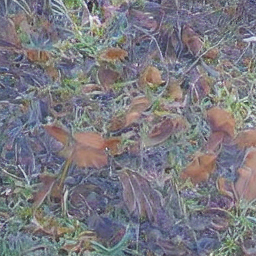

In [49]:
latent_to_img(teacher2, img)

# Teacher predicting in steps

In [2]:
from util_x0 import *
import wandb

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2

config_path=f"{cwd}/models/configs/cin256-v2-x0.yaml"
model_path=f"{cwd}/models/cin256_original.ckpt"

teacher = create_models(config_path, model_path, student=False)


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [6]:
NUM_CLASSES = 1000
generations = 1
# intermediate_generation = generations // 5
ddim_steps_teacher = 400
ddim_steps_student = int(ddim_steps_teacher / 2)
TEACHER_STEPS = 2
STUDENT_STEPS = 1
ddim_eta = 0.01
scale = 3.0
updates = int(ddim_steps_teacher / TEACHER_STEPS)


teacher.num_timesteps = ddim_steps_teacher

with torch.no_grad():
    with teacher.ema_scope():
            
            # for class_prompt in tqdm.tqdm(torch.randint(0, NUM_CLASSES, (generations,))):
            
            with tqdm.tqdm(torch.randint(0, NUM_CLASSES, (generations,))) as tepoch:
                
                for i, class_prompt in enumerate(tepoch):
                    img = None
                    # xc = torch.tensor([class_prompt])
                    xc = torch.tensor([992])
                    c = teacher.get_learned_conditioning({teacher.cond_stage_key: xc.to(teacher.device)})

                    for steps in range(updates):          
                                                     
                        img, x0, x_T_copy = teacher.iterative_progressive_denoising(cond=c, shape=[3, 64, 64], verbose=True, callback=None, quantize_denoised=False,
                              img_callback=None, mask=None, x0=None, temperature=1., noise_dropout=0.,
                              score_corrector=None, corrector_kwargs=None, batch_size=1, x_T=img, start_T=steps*2,
                              log_every_t=None, keep_intermediates=True)
                        

100%|██████████| 1/1 [00:22<00:00, 22.09s/it]


# Generate a prediction

In [3]:
image, _, _ = generate(teacher, x0=True)

TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

# Training student on teacher